In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from multiplicity_helper import *
from plot_figures_integrated import *

In [17]:
# processing model output pkl files
def process_pkl_no_eps(score_method):
    # score_method: [ [],[], []], each list from a random seed. num_itr x [] score_list
    # score_method[seed][eps_key] -> [],[],[] #itr x score_list
    # reorganize into: [[from itr1], [from itr2], []], each list from a itr. []: num_seed x score
    num_itr = len(score_method[0])
    score_compiled = [[] for i in range(num_itr)]
    # reorganize 
    for score_seed in score_method:
        for i in range(num_itr):
            score_compiled[i].append(score_seed[i])
    return score_compiled
def process_scores_per_itr(folder_path, model, fair='eo', start_seed = 33, end_seed = 42):
    # return dic {eps1:[[from itr1], [from itr2], [from itr3]], eps2:...} 
    # or list [[from itr1], [from itr2], ...]
    # [from itr_i]: num_seed x score_list
    score_original = []
    for seed in range(start_seed, end_seed+1):
        file_path = folder_path + 'scores_original_'+model+'_s{}_itr10_.pkl'.format(seed)
        with open(file_path, 'rb+') as f: 
            original = pickle.load(f)
        score_original.append(original)
    # reorg score to prep for multiplicity
    score_original = process_pkl_no_eps(score_original)
    return score_original

In [54]:
#folder_path = "baseline-methods/enem/results/"
#folder_path = "enem/benchmarks/results/"
folder_path = "baseline-methods/intersectional/enem/results/"
score_original = process_scores_per_itr(folder_path, 'rf2', fair='eo', start_seed = 33, end_seed = 42)

10


In [55]:
print(np.array(score_original).shape)

(10, 10, 7500, 1)


In [56]:
# following can be "enem"/"german"
data = "enem"
if data == "enem":
    path = './data/'
    df = pd.read_pickle(path+'ENEM/enem-50000-20.pkl')
    label_name = 'gradebin'
    #protected_attrs = ['racebin', 'sexbin']
    protected_attrs = ['racebin']
    label_name = 'gradebin'
    df[label_name] = df[label_name].astype(int)    

Text(0, 0.5, 'cumulative dist')

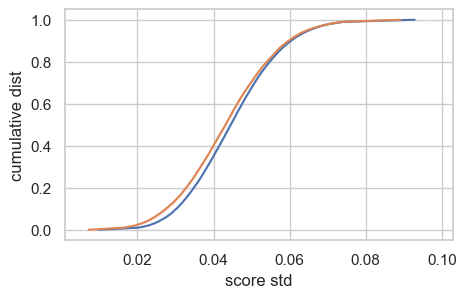

In [64]:
#percentile list per iteration
v_plot_list = [] 
for i in range(10):
    score_list = score_original[i]
    score_sd_per_sample = pd.DataFrame(np.squeeze(score_list)).std() # len(scores)*1
    assert(score_sd_per_sample.shape == (7500,))
    # get group attribute
    dataset_orig_train, dataset_orig_vt = train_test_split(df, test_size=0.3, random_state=i)    
    dataset_orig_valid, dataset_orig_test = train_test_split(dataset_orig_vt, test_size=0.5, random_state=i)    
    
    X_test = dataset_orig_test
    # test dataset with group attributes and score_std per sample 
    pred_table = pd.DataFrame(data=X_test, copy=True)
    pred_table = pred_table[protected_attrs]
    pred_table["group score std"] = np.array(score_sd_per_sample)
    
    # get percentile score_std for each group
    t = np.linspace(0,1,100)
    v = [pred_table.groupby(protected_attrs).quantile(t_ix)['group score std'].to_numpy() for t_ix in t] # |t|* |protected_attrs|
    v_plot_list.append(v)

fig, ax = plt.subplots(1, 1, figsize=(5, 3))
# plot mean and std across itr
v_plot_mean = np.mean(v_plot_list,axis = 0) # (100,2)
assert(v_plot_mean.shape == (100,2))
v_plot_std = np.std(v_plot_list, axis = 0, ddof=1) # (100, 2)
assert(v_plot_std.shape == (100,2))
# plot mean and std across itr
v_plot_mean = np.mean(v_plot_list,axis = 0) # (100,2)
v_plot_std = np.std(v_plot_list, axis = 0, ddof=1) # (100, 2)

t = np.linspace(0,1,100)
# for plotting various settings. 0: NonWhite, 1: White
# Compare between groups
ax.plot( v_plot_mean[:,0], t, label = "Baseline, NonWhite")
ax.fill_betweenx(t, v_plot_mean[:,0]+ v_plot_std[:,0],
                v_plot_mean[:,0] - v_plot_std[:,0],  alpha=0.2)

ax.plot( v_plot_mean[:,1], t, label = "Baseline, White")
ax.fill_betweenx(t, v_plot_mean[:,1]+ v_plot_std[:,1],
                v_plot_mean[:,1] - v_plot_std[:,1],  alpha=0.2)

plt.xlabel('score std')
plt.ylabel('cumulative dist')

In [58]:
meo_list_all = []
acc_list_all = []
for i in range(10):
    meo_list, acc_list = get_eo_acc("enem", score_original[i],i)
    for j in range(len(meo_list)):
        meo_list_all.append(meo_list[j])
        acc_list_all.append(acc_list[j])
print(np.min(meo_list_all), np.max(meo_list_all))
print(np.array(acc_list_all).min(), np.array(acc_list_all).max())

0.2259899722149772 0.28189910913444793
0.6569333333333334 0.6721333333333334


Text(0, 0.5, 'cumulative dist')

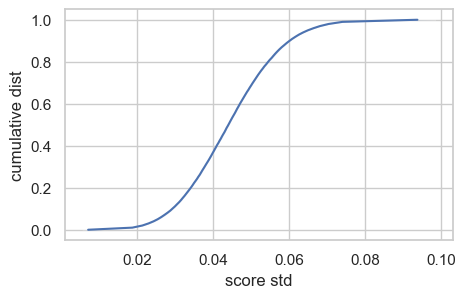

In [69]:
#percentile list per iteration
v_plot_list = [] 
for i in range(10):
    score_list = score_original[i]
    score_sd_per_sample = pd.DataFrame(np.squeeze(score_list)).std() # len(scores)*1
    assert(score_sd_per_sample.shape == (7500,))
    # get percentile score_std for each group
    t = np.linspace(0,1,100)
    v = [score_sd_per_sample.quantile(t_ix) for t_ix in t] # |t|* |protected_attrs|
    v_plot_list.append(v)

fig, ax = plt.subplots(1, 1, figsize=(5, 3))
# plot mean and std across itr
v_plot_mean = np.mean(v_plot_list,axis = 0) # (100)
assert(v_plot_mean.shape == (100,))
v_plot_std = np.std(v_plot_list, axis = 0, ddof=1) # (100, 2)
assert(v_plot_std.shape == (100,))
# plot mean and std across itr
v_plot_mean = np.mean(v_plot_list,axis = 0) # (100,2)
v_plot_std = np.std(v_plot_list, axis = 0, ddof=1) # (100, 2)

t = np.linspace(0,1,100)
# for plotting various settings. 0: NonWhite, 1: White
# Compare between groups
ax.plot( v_plot_mean, t, label = "Baseline")
ax.fill_betweenx(t, v_plot_mean+ v_plot_std,
                v_plot_mean - v_plot_std,  alpha=0.2)

plt.xlabel('score std')
plt.ylabel('cumulative dist')